In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from keras.layers.core import Dense, Activation, Dropout
import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
import time
from numpy import newaxis
import warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse

In [6]:
def normalise_windows(window_data):
    normalised_data = []
    normalised_window_0 = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
        normalised_window_0.append(window[0])
    return (normalised_data,normalised_window_0)
#divides each value 

In [7]:
def reverse_normalise(y, reverse, start_val):
    normalised_data = []
    i = start_val
    for valuey in y:
        value = ((float(valuey)+1) * float(reverse[i])) 
        normalised_data.append(value)
        i = i+1
    return normalised_data

In [8]:
def set_data(stock, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])
        
        result, result_reverse = normalise_windows(result)
        
        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        np.random.shuffle(train)
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test, result_reverse, row)
    #except:
        #print("file" + stock + ".csv not found")


In [9]:
def get_test_data(ticker, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ ticker +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length):
            result.append(seq[index: index + sequence_length])
    
        result = normalise_windows(result)
        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        np.random.shuffle(train)
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        return (x_test, y_test)


    

In [10]:
def set_stock_list():
    arr = []
    with open("../NASDAQ.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(',')
            arr.append(currentline)
    newarr = np.array(arr[0])
    return newarr

In [11]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [12]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted


In [13]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [14]:
def plot_results_multiple(predicted_data, true_data, prediction_len, stock):
    fig = plt.figure(facecolor='white',figsize = (14,4))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.title(stock + " Closing Stock Price")
        plt.legend()
    plt.show()

In [15]:
from keras.models import load_model
#model.save('stock_NN.h5')

In [16]:
def accuracy(y_true, y_pred):
    prev_true = y_true[0]
    prev_pred = y_pred[0]
    correct = 0
    incorrect = 0
    for i in range(1,len(predicted)):
        if prev_true < y_true[i] and prev_true < y_pred[i]:
            correct = correct+1
        elif prev_true > y_true[i] and prev_true > y_pred[i]:
            correct = correct+1
        else:
            incorrect = incorrect+1
        prev_true = y_true[i]
        prev_pred = y_pred[i]        
    return (correct, incorrect)

In [17]:
def build_model(shape):
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(shape,1)))
    regressor.add(Dropout(0.4))
    # Second LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.4))
    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    #model.add(Activation('sigmoid'))
    # Fourth LSTM layer 
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    # The output layer
   
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [18]:
seq_length = 200

In [19]:
model = build_model(seq_length)

In [21]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [63]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [38]:

epochs = 1
#stock_list = set_stock_list()
for stock in stock_list:
    print(stock)
    try:
        x_train,x_test,y_train,y_test, reverse, row = set_data(stock , seq_length)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 256,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("not found")



AMZN
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.0113 - val_loss: 6.9972e-04
MSFT
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 0.0012
GOOGL
Train on 3550 samples, validate on 187 samples
Epoch 1/1
3550/3550 [==============================] - 5s 2ms/step - loss: 0.0051 - val_loss: 0.0010
CTSH
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 1ms/step - loss: 0.0093 - val_loss: 0.0012
VIVO
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.0048 - val_loss: 0.0017
IBM
Train on 4590 samples, validate on 242 samples
Epoch 1/1
4590/4590 [==============================] - 7s 1ms/step - loss: 0.0019 - val_loss: 9.8029e-04
CSCO
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [=

4590/4590 [==============================] - 7s 2ms/step - loss: 0.0034 - val_loss: 0.0013
LOW
Train on 4590 samples, validate on 242 samples
Epoch 1/1
4590/4590 [==============================] - 7s 2ms/step - loss: 0.0055 - val_loss: 0.0027
MA
not found
MCD
Train on 4590 samples, validate on 242 samples
Epoch 1/1
4590/4590 [==============================] - 7s 2ms/step - loss: 0.0033 - val_loss: 0.0011
MDLZ
Train on 4308 samples, validate on 227 samples
Epoch 1/1
4308/4308 [==============================] - 7s 2ms/step - loss: 0.0029 - val_loss: 9.2804e-04
MDT
Train on 4590 samples, validate on 242 samples
Epoch 1/1
4590/4590 [==============================] - 7s 2ms/step - loss: 0.0029 - val_loss: 0.0012
MET
Train on 4584 samples, validate on 241 samples
Epoch 1/1
4584/4584 [==============================] - 7s 2ms/step - loss: 0.0049 - val_loss: 0.0021
MMM
Train on 4590 samples, validate on 242 samples
Epoch 1/1
4590/4590 [==============================] - 7s 2ms/step - loss: 0.003

In [39]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('TCCO',seq_length)
y_test_graph = reverse_normalise(y_test, for_reverse, row)

In [40]:
predicted = predict_point_by_point(model, x_test)
predicted_graph = reverse_normalise(predicted, for_reverse, row)
mse(y_test,predicted)

0.04167266232449542

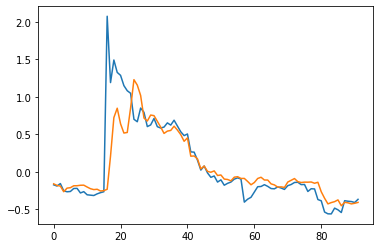

In [41]:
plt.plot(y_test[150:])
plt.plot(predicted[150:])


In [42]:
correct , incorrect= accuracy(y_test, predicted)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

number correct: 157
number incorrect 84
percetage correct: 0.6514522821576764


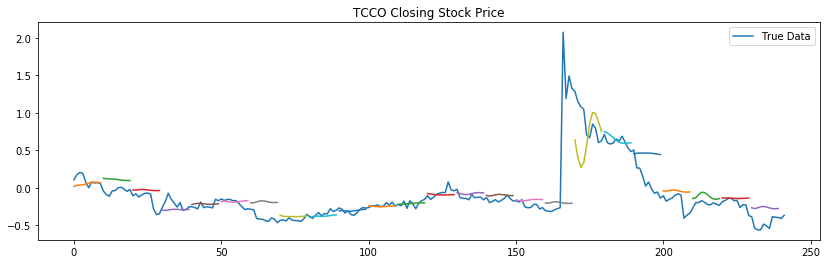

In [43]:
predictions = predict_sequences_multiple(model, x_test, seq_length,10)
plot_results_multiple(predictions, y_test, 10, 'TCCO') 

In [64]:
best = 0.0000001
average = 0
length = 0

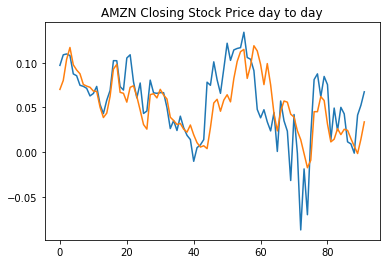

AMZN  number correct: 165
AMZN  number incorrect 76
AMZN  percetage correct: 0.6846473029045643


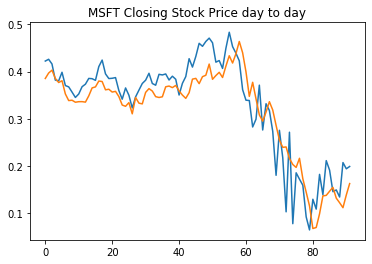

MSFT  number correct: 156
MSFT  number incorrect 85
MSFT  percetage correct: 0.6473029045643154


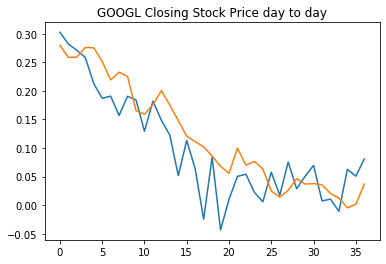

GOOGL  number correct: 128
GOOGL  number incorrect 58
GOOGL  percetage correct: 0.6881720430107527


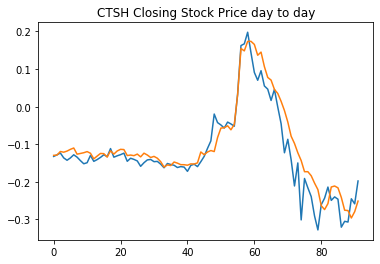

CTSH  number correct: 165
CTSH  number incorrect 76
CTSH  percetage correct: 0.6846473029045643


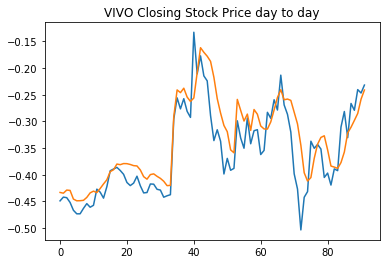

VIVO  number correct: 135
VIVO  number incorrect 106
VIVO  percetage correct: 0.5601659751037344


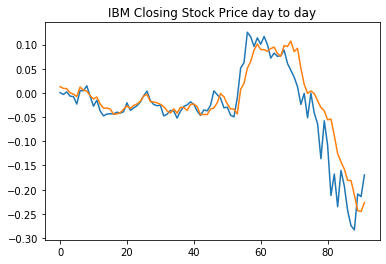

IBM  number correct: 168
IBM  number incorrect 73
IBM  percetage correct: 0.6970954356846473


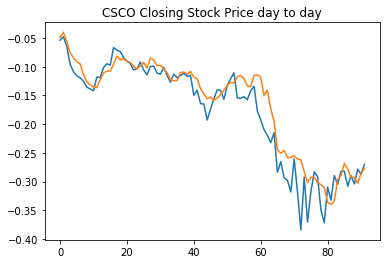

CSCO  number correct: 170
CSCO  number incorrect 71
CSCO  percetage correct: 0.7053941908713693


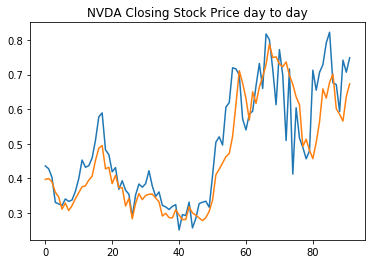

NVDA  number correct: 158
NVDA  number incorrect 83
NVDA  percetage correct: 0.6556016597510373


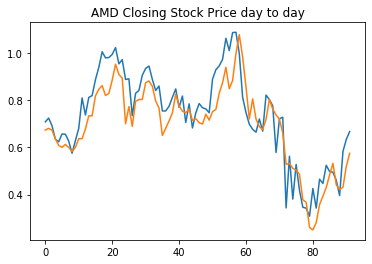

AMD  number correct: 169
AMD  number incorrect 72
AMD  percetage correct: 0.7012448132780082


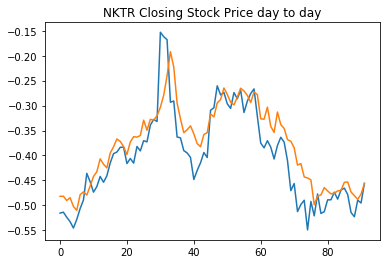

NKTR  number correct: 140
NKTR  number incorrect 101
NKTR  percetage correct: 0.5809128630705395


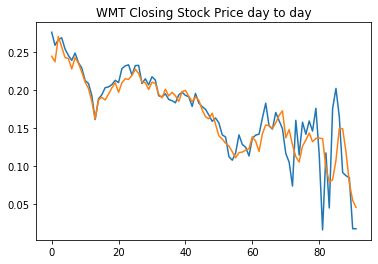

WMT  number correct: 164
WMT  number incorrect 77
WMT  percetage correct: 0.6804979253112033


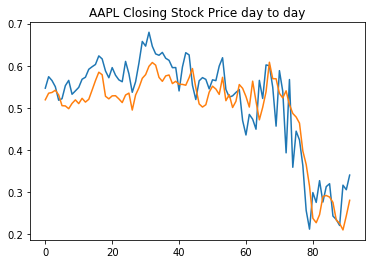

AAPL  number correct: 153
AAPL  number incorrect 88
AAPL  percetage correct: 0.6348547717842323


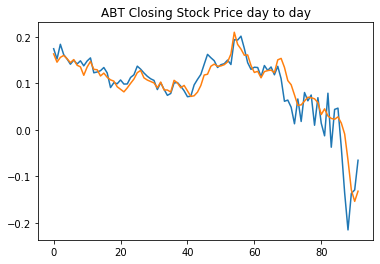

ABT  number correct: 168
ABT  number incorrect 73
ABT  percetage correct: 0.6970954356846473


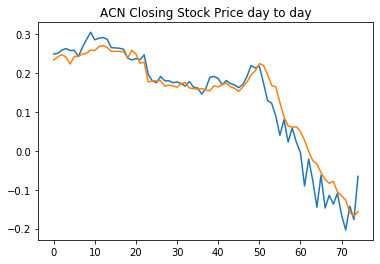

ACN  number correct: 152
ACN  number incorrect 72
ACN  percetage correct: 0.6785714285714286


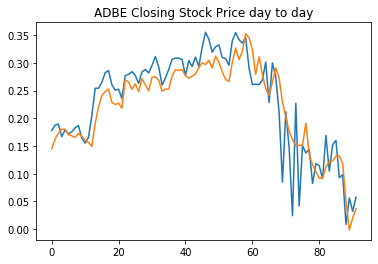

ADBE  number correct: 169
ADBE  number incorrect 72
ADBE  percetage correct: 0.7012448132780082


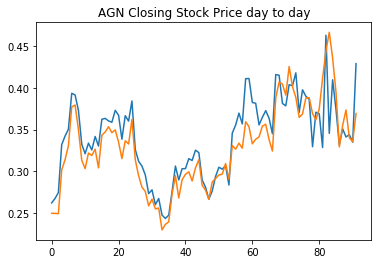

AGN  number correct: 158
AGN  number incorrect 83
AGN  percetage correct: 0.6556016597510373


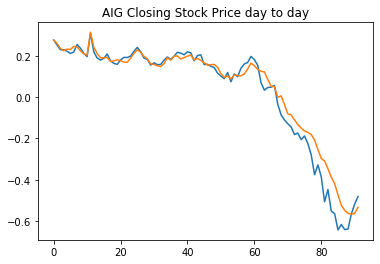

AIG  number correct: 158
AIG  number incorrect 83
AIG  percetage correct: 0.6556016597510373


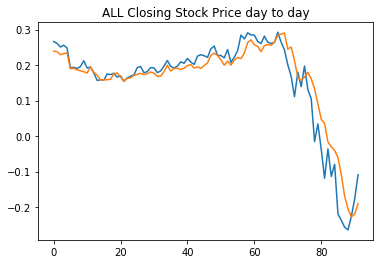

ALL  number correct: 158
ALL  number incorrect 83
ALL  percetage correct: 0.6556016597510373


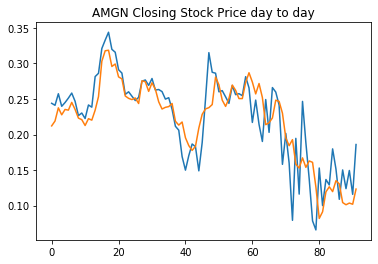

AMGN  number correct: 157
AMGN  number incorrect 84
AMGN  percetage correct: 0.6514522821576764
not found


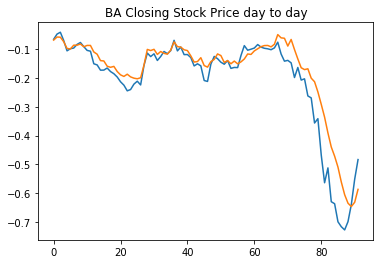

BA  number correct: 158
BA  number incorrect 83
BA  percetage correct: 0.6556016597510373


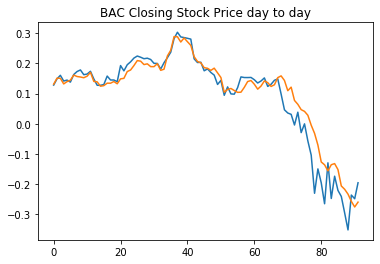

BAC  number correct: 157
BAC  number incorrect 84
BAC  percetage correct: 0.6514522821576764


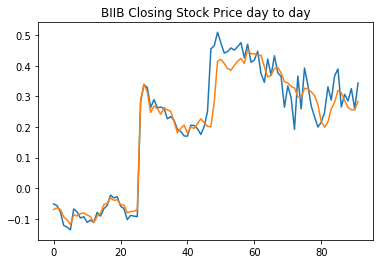

BIIB  number correct: 146
BIIB  number incorrect 95
BIIB  percetage correct: 0.6058091286307054


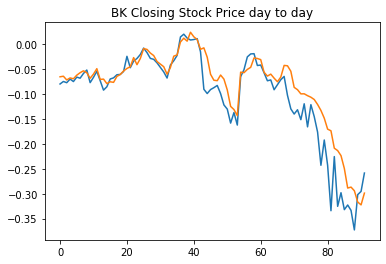

BK  number correct: 150
BK  number incorrect 91
BK  percetage correct: 0.6224066390041494


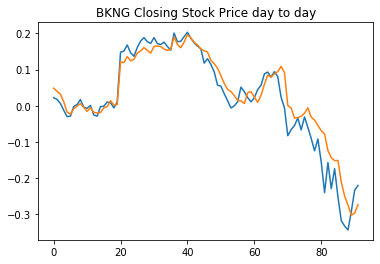

BKNG  number correct: 156
BKNG  number incorrect 85
BKNG  percetage correct: 0.6473029045643154
not found


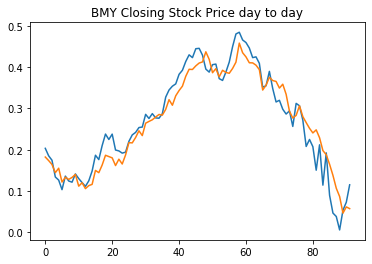

BMY  number correct: 155
BMY  number incorrect 86
BMY  percetage correct: 0.6431535269709544


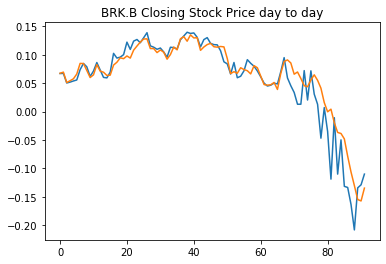

BRK.B  number correct: 170
BRK.B  number incorrect 71
BRK.B  percetage correct: 0.7053941908713693


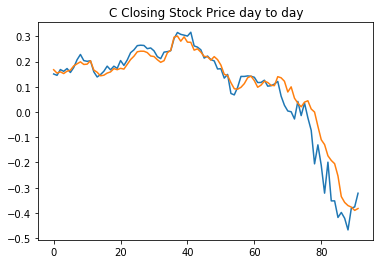

C  number correct: 164
C  number incorrect 77
C  percetage correct: 0.6804979253112033


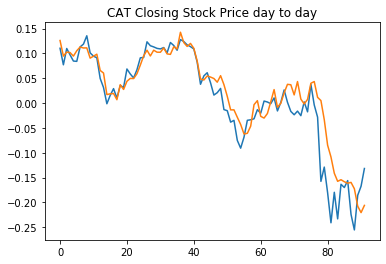

CAT  number correct: 161
CAT  number incorrect 80
CAT  percetage correct: 0.6680497925311203
not found


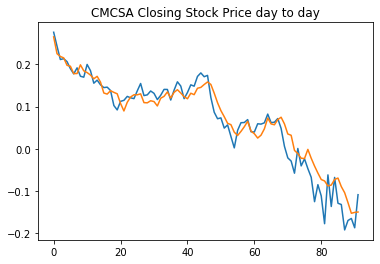

CMCSA  number correct: 164
CMCSA  number incorrect 77
CMCSA  percetage correct: 0.6804979253112033


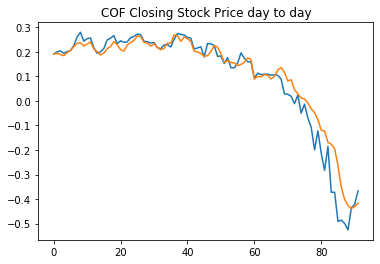

COF  number correct: 157
COF  number incorrect 84
COF  percetage correct: 0.6514522821576764


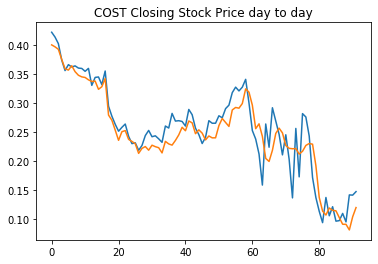

COST  number correct: 154
COST  number incorrect 87
COST  percetage correct: 0.6390041493775933


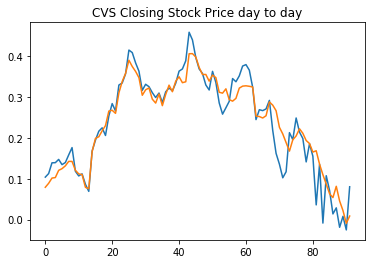

CVS  number correct: 164
CVS  number incorrect 77
CVS  percetage correct: 0.6804979253112033
not found
not found


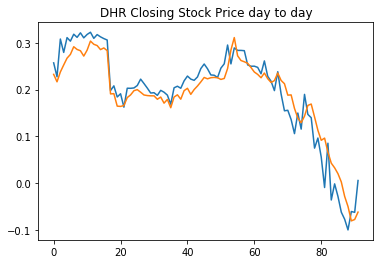

DHR  number correct: 153
DHR  number incorrect 88
DHR  percetage correct: 0.6348547717842323


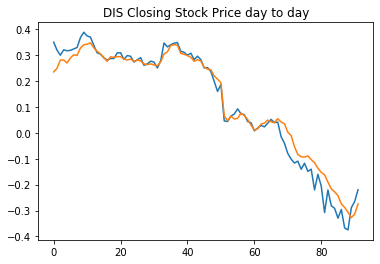

DIS  number correct: 163
DIS  number incorrect 78
DIS  percetage correct: 0.6763485477178424


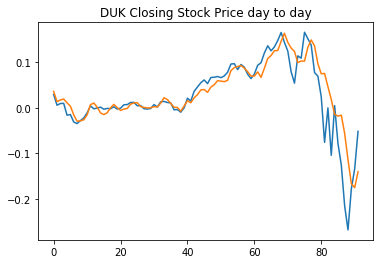

DUK  number correct: 162
DUK  number incorrect 79
DUK  percetage correct: 0.6721991701244814
not found


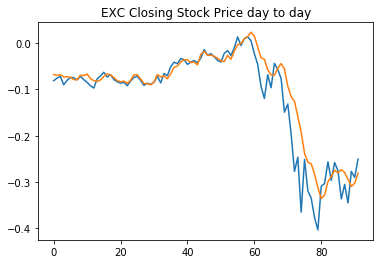

EXC  number correct: 162
EXC  number incorrect 79
EXC  percetage correct: 0.6721991701244814


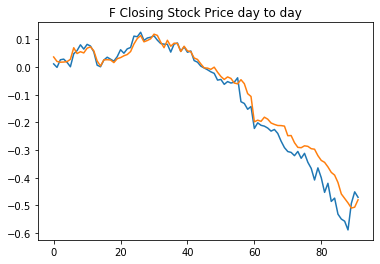

F  number correct: 152
F  number incorrect 89
F  percetage correct: 0.6307053941908713


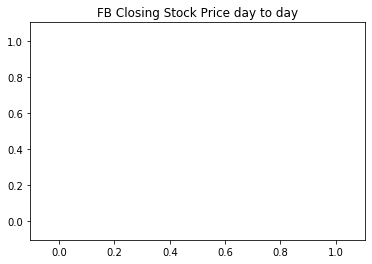

FB  number correct: 54
FB  number incorrect 34
FB  percetage correct: 0.6136363636363636


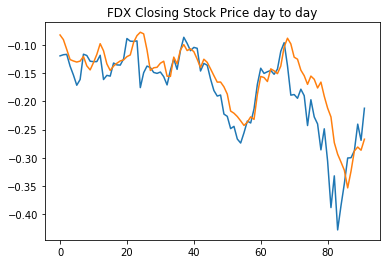

FDX  number correct: 155
FDX  number incorrect 86
FDX  percetage correct: 0.6431535269709544


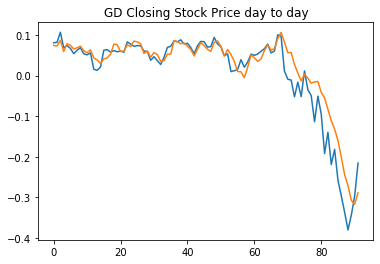

GD  number correct: 169
GD  number incorrect 72
GD  percetage correct: 0.7012448132780082
not found


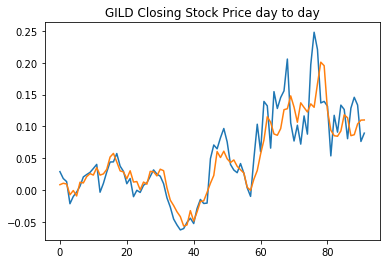

GILD  number correct: 180
GILD  number incorrect 61
GILD  percetage correct: 0.7468879668049793


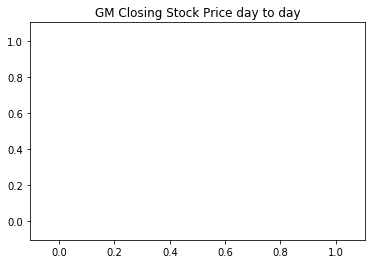

GM  number correct: 53
GM  number incorrect 54
GM  percetage correct: 0.4953271028037383


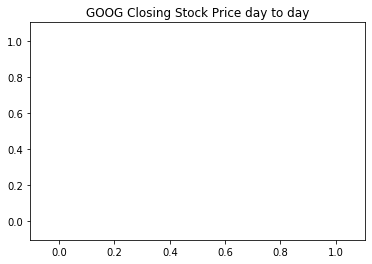

GOOG  number correct: 40
GOOG  number incorrect 25
GOOG  percetage correct: 0.6153846153846154


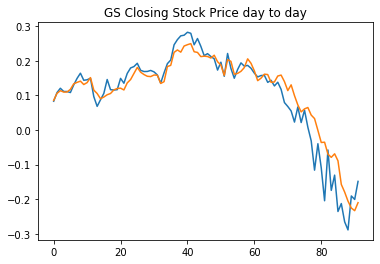

GS  number correct: 157
GS  number incorrect 84
GS  percetage correct: 0.6514522821576764
not found


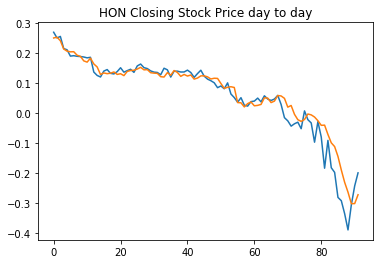

HON  number correct: 155
HON  number incorrect 86
HON  percetage correct: 0.6431535269709544


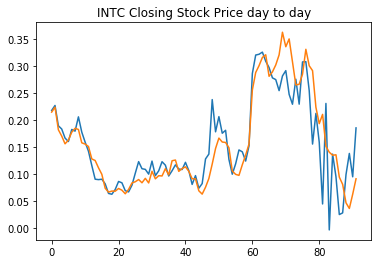

INTC  number correct: 164
INTC  number incorrect 77
INTC  percetage correct: 0.6804979253112033


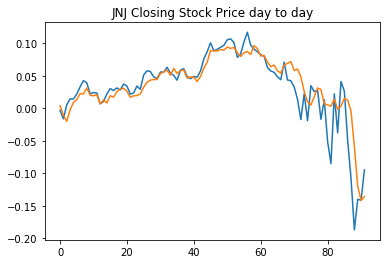

JNJ  number correct: 148
JNJ  number incorrect 93
JNJ  percetage correct: 0.6141078838174274


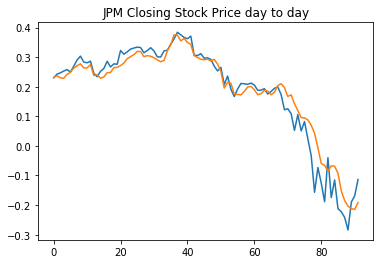

JPM  number correct: 148
JPM  number incorrect 93
JPM  percetage correct: 0.6141078838174274


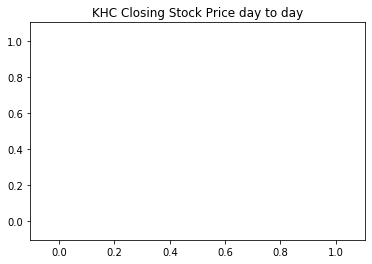

KHC  number correct: 26
KHC  number incorrect 23
KHC  percetage correct: 0.5306122448979592


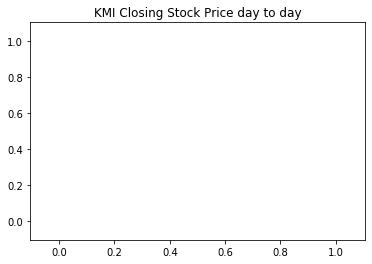

KMI  number correct: 70
KMI  number incorrect 34
KMI  percetage correct: 0.6730769230769231


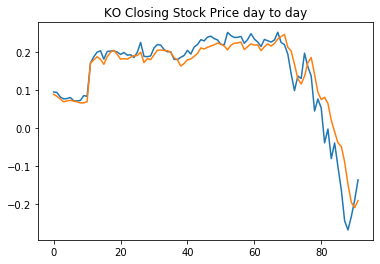

KO  number correct: 152
KO  number incorrect 89
KO  percetage correct: 0.6307053941908713


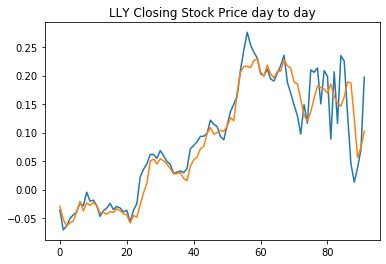

LLY  number correct: 160
LLY  number incorrect 81
LLY  percetage correct: 0.6639004149377593


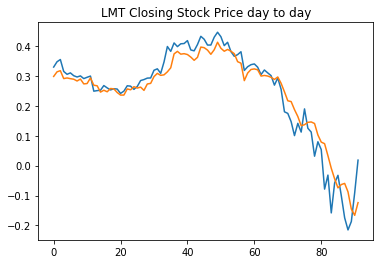

LMT  number correct: 153
LMT  number incorrect 88
LMT  percetage correct: 0.6348547717842323


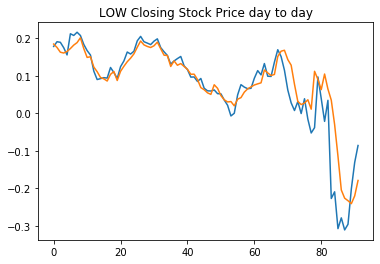

LOW  number correct: 170
LOW  number incorrect 71
LOW  percetage correct: 0.7053941908713693
not found


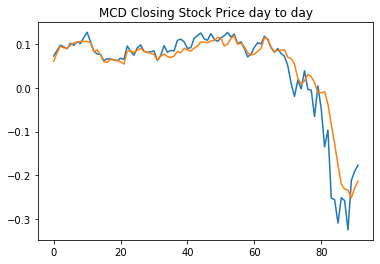

MCD  number correct: 152
MCD  number incorrect 89
MCD  percetage correct: 0.6307053941908713


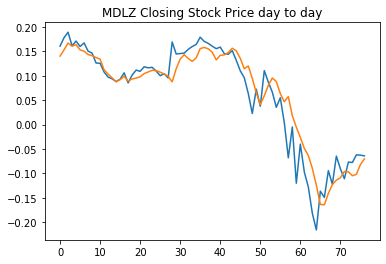

MDLZ  number correct: 147
MDLZ  number incorrect 79
MDLZ  percetage correct: 0.6504424778761062


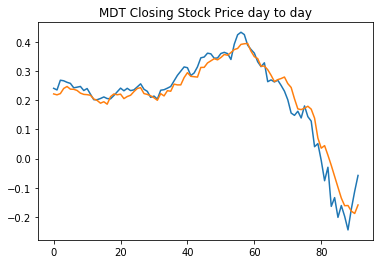

MDT  number correct: 150
MDT  number incorrect 91
MDT  percetage correct: 0.6224066390041494


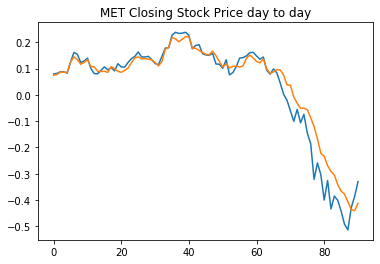

MET  number correct: 168
MET  number incorrect 72
MET  percetage correct: 0.7


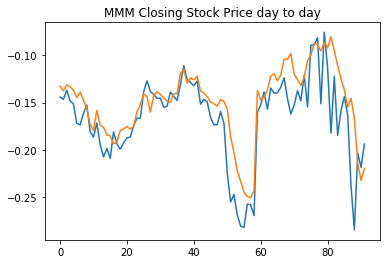

MMM  number correct: 141
MMM  number incorrect 100
MMM  percetage correct: 0.5850622406639004
not found


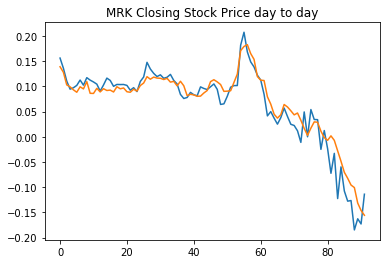

MRK  number correct: 163
MRK  number incorrect 78
MRK  percetage correct: 0.6763485477178424


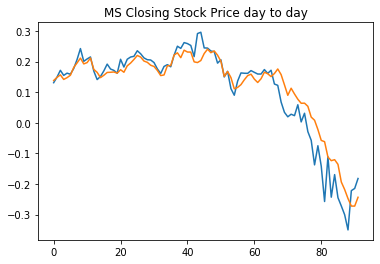

MS  number correct: 162
MS  number incorrect 79
MS  percetage correct: 0.6721991701244814


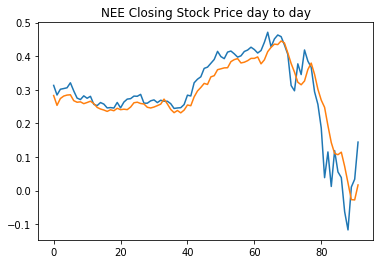

NEE  number correct: 128
NEE  number incorrect 113
NEE  percetage correct: 0.5311203319502075


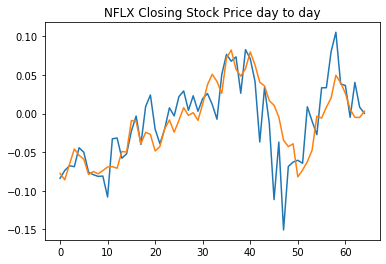

NFLX  number correct: 155
NFLX  number incorrect 59
NFLX  percetage correct: 0.7242990654205608
not found


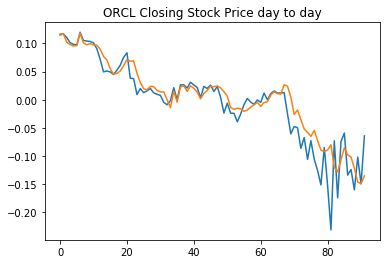

ORCL  number correct: 168
ORCL  number incorrect 73
ORCL  percetage correct: 0.6970954356846473


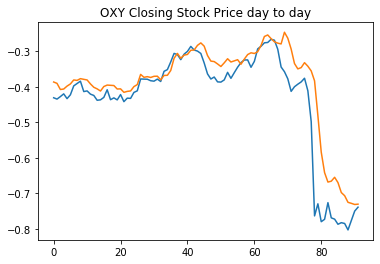

OXY  number correct: 127
OXY  number incorrect 114
OXY  percetage correct: 0.5269709543568465


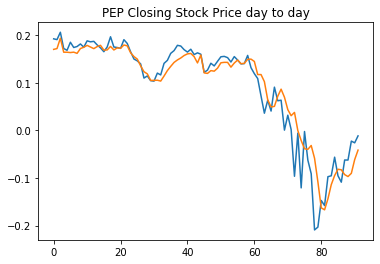

PEP  number correct: 161
PEP  number incorrect 80
PEP  percetage correct: 0.6680497925311203


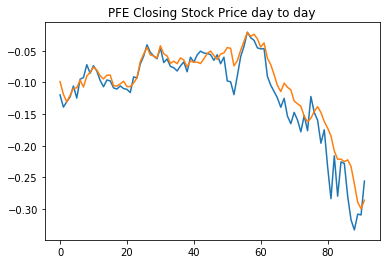

PFE  number correct: 153
PFE  number incorrect 88
PFE  percetage correct: 0.6348547717842323
not found


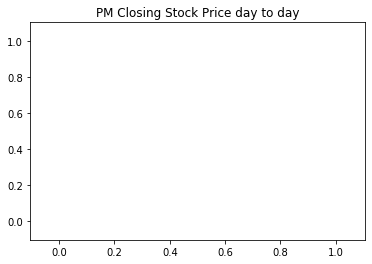

PM  number correct: 92
PM  number incorrect 48
PM  percetage correct: 0.6571428571428571


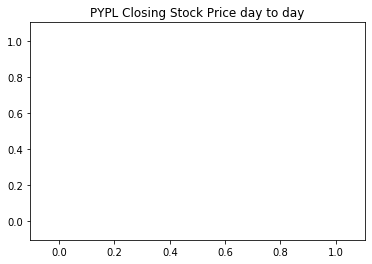

PYPL  number correct: 29
PYPL  number incorrect 20
PYPL  percetage correct: 0.5918367346938775


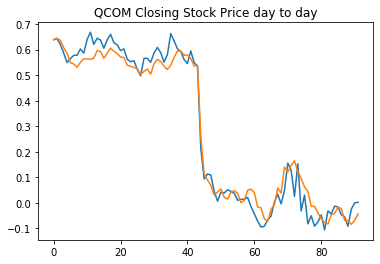

QCOM  number correct: 158
QCOM  number incorrect 83
QCOM  percetage correct: 0.6556016597510373


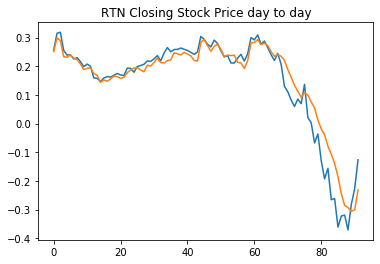

RTN  number correct: 152
RTN  number incorrect 89
RTN  percetage correct: 0.6307053941908713


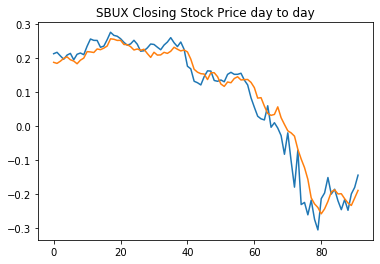

SBUX  number correct: 147
SBUX  number incorrect 94
SBUX  percetage correct: 0.6099585062240664
not found


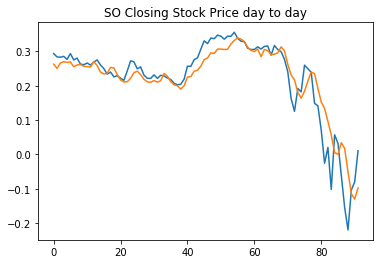

SO  number correct: 156
SO  number incorrect 85
SO  percetage correct: 0.6473029045643154


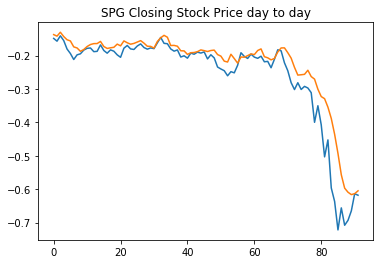

SPG  number correct: 140
SPG  number incorrect 101
SPG  percetage correct: 0.5809128630705395


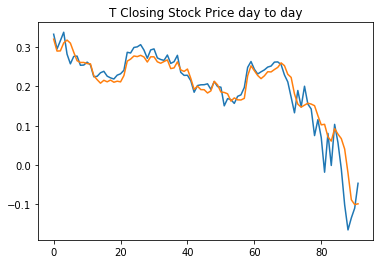

T  number correct: 153
T  number incorrect 88
T  percetage correct: 0.6348547717842323


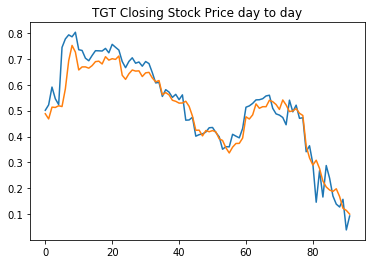

TGT  number correct: 154
TGT  number incorrect 87
TGT  percetage correct: 0.6390041493775933


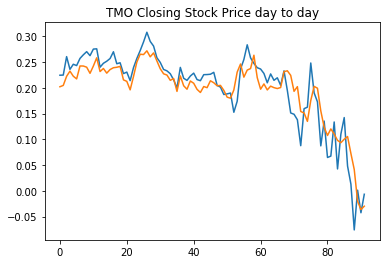

TMO  number correct: 140
TMO  number incorrect 101
TMO  percetage correct: 0.5809128630705395


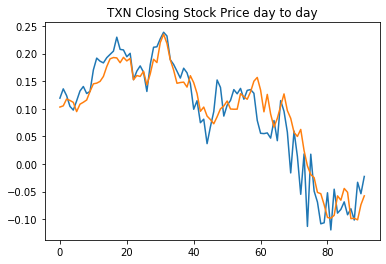

TXN  number correct: 166
TXN  number incorrect 75
TXN  percetage correct: 0.6887966804979253


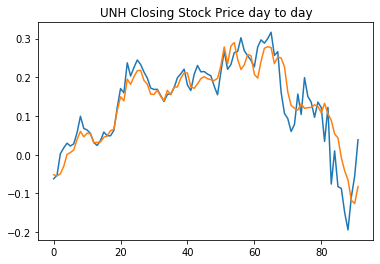

UNH  number correct: 161
UNH  number incorrect 80
UNH  percetage correct: 0.6680497925311203


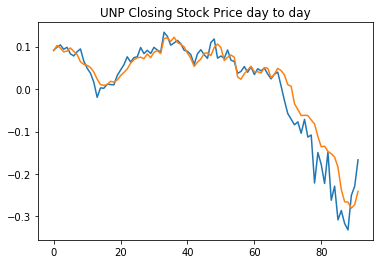

UNP  number correct: 153
UNP  number incorrect 88
UNP  percetage correct: 0.6348547717842323


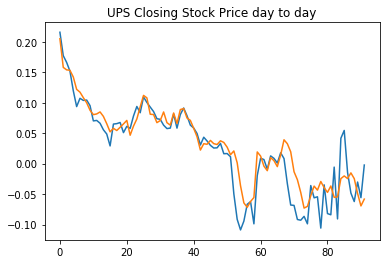

UPS  number correct: 160
UPS  number incorrect 81
UPS  percetage correct: 0.6639004149377593


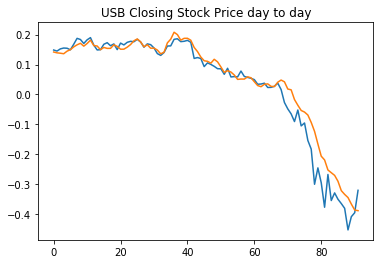

USB  number correct: 150
USB  number incorrect 91
USB  percetage correct: 0.6224066390041494


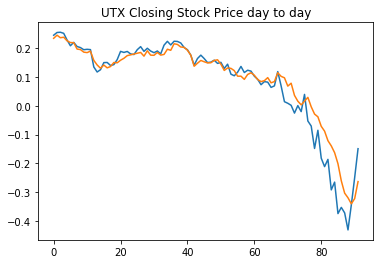

UTX  number correct: 163
UTX  number incorrect 78
UTX  percetage correct: 0.6763485477178424
not found


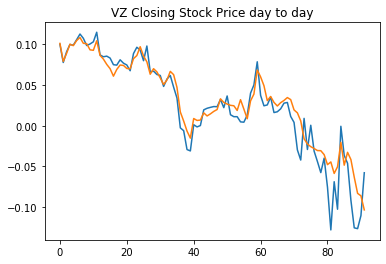

VZ  number correct: 166
VZ  number incorrect 75
VZ  percetage correct: 0.6887966804979253


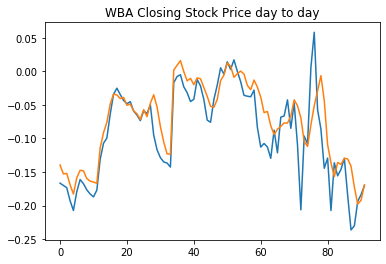

WBA  number correct: 138
WBA  number incorrect 103
WBA  percetage correct: 0.5726141078838174


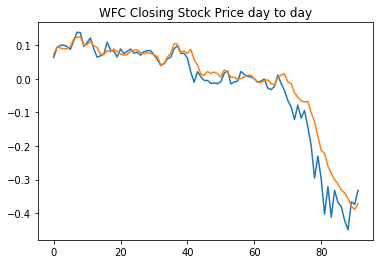

WFC  number correct: 159
WFC  number incorrect 82
WFC  percetage correct: 0.6597510373443983


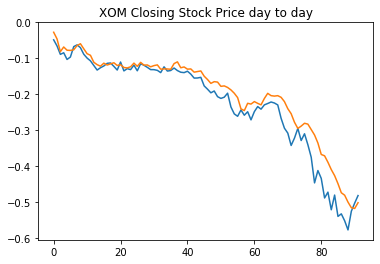

XOM  number correct: 141
XOM  number incorrect 100
XOM  percetage correct: 0.5850622406639004
best stock: GILD
score:  0.7468879668049793
average:  0.6471149400209929


In [65]:
#10 works best
for stock in stock_list:
    try:
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        predicted = predict_point_by_point(model, x_test)
        y_test_graph = reverse_normalise(y_test, for_reverse, row)
        predicted_graph = reverse_normalise(predicted, for_reverse, row)
        plt.plot(y_test[150:])
        plt.plot(predicted[150:])
        plt.title(stock + " Closing Stock Price day to day")
        plt.show()
        correct , incorrect = accuracy(y_test, predicted)
        print(stock, " number correct:", correct)
        print(stock," number incorrect", incorrect)
        print(stock," percetage correct:", float(correct/(correct+incorrect)))
        average = average + float(correct/(correct+incorrect))
        length = length + 1
        if float(correct/(correct+incorrect)) > best:
            best = float(correct/(correct+incorrect))
            best_stock = stock
    except:
        print("not found")
print("best stock:",best_stock)
print("score: ",best)
print("average: ", float(average/length))

In [46]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

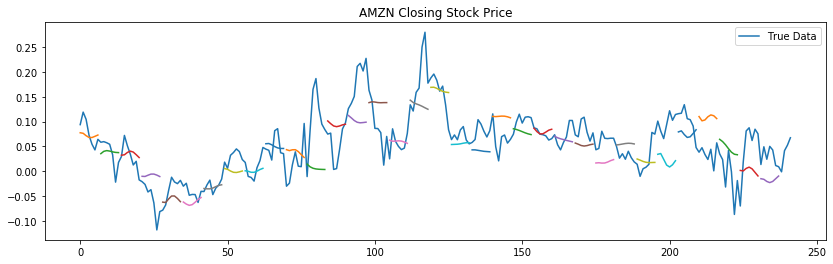

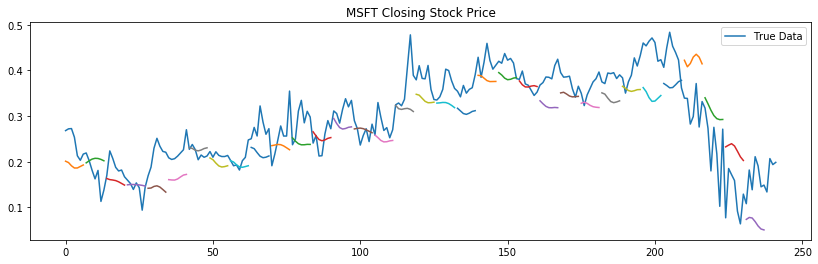

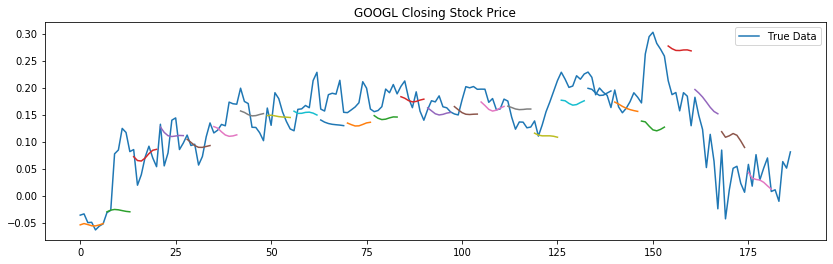

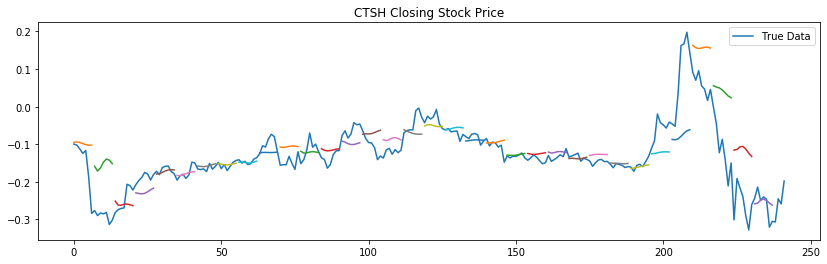

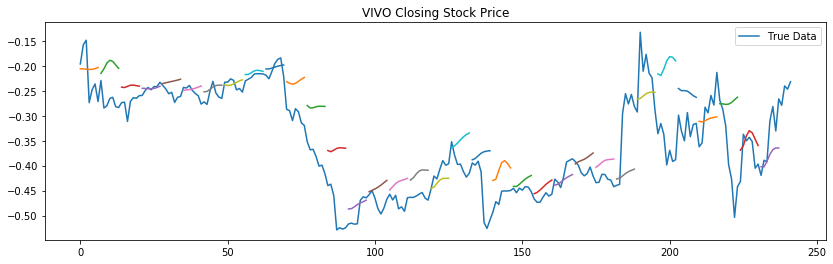

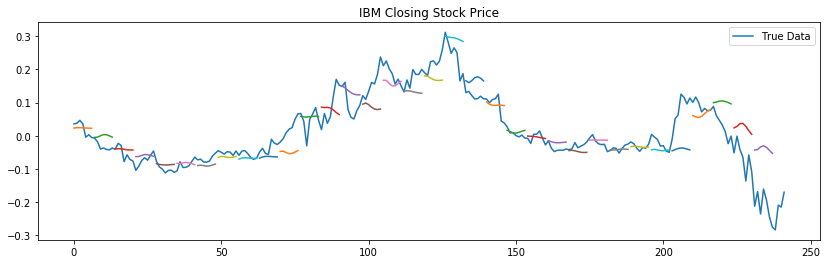

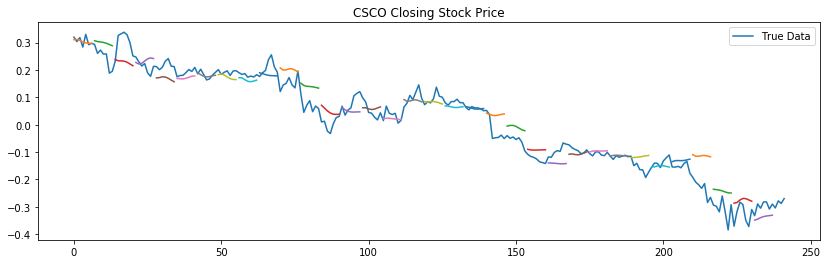

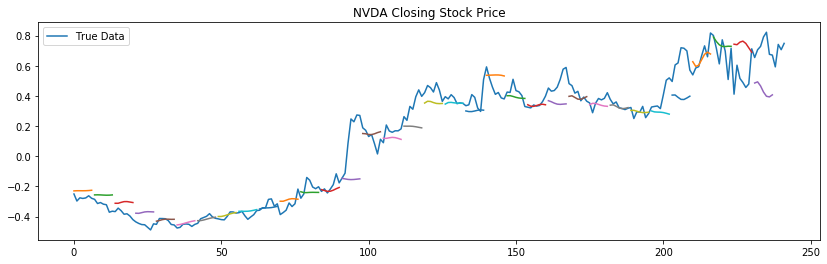

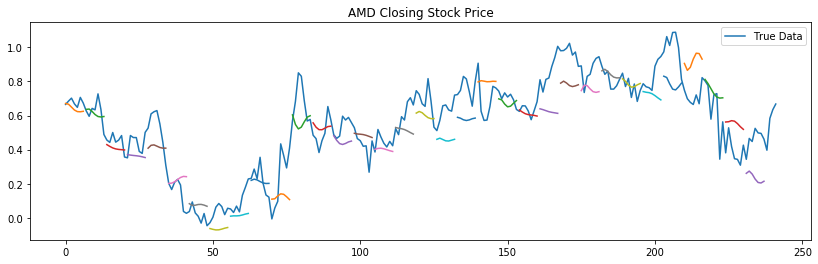

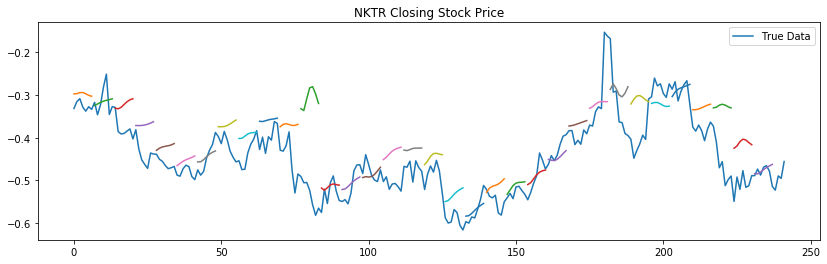

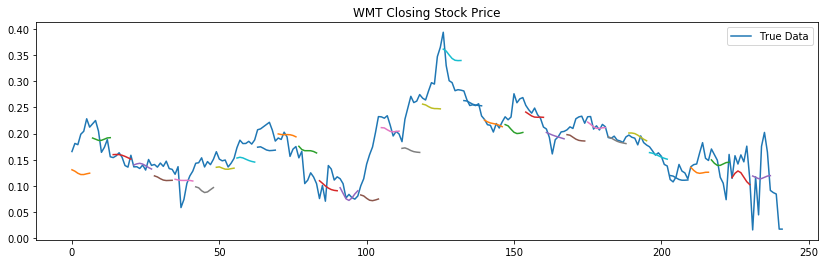

In [47]:
for stock in stock_list:
    x_train,x_test,y_train,y_test, result, row = set_data(stock , seq_length)
    predictions = predict_sequences_multiple(model, x_test, seq_length,7)
    plot_results_multiple(predictions, y_test, 7, stock) 

In [48]:
model.save('stock_nn_'+ str(epochs)+'epochs_'+str(seq_length)+'bestRandom.h5')

In [62]:
model = load_model('stock_nn_1epochs_200bestRandom.h5')

In [49]:
def predict_future(stock, days, model):
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        prev_predicted = predict_point_by_point(model, x_test)
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        prev_predicted = np.append(prev_predicted,newPredicted)
        for i in range(2,days+1):
            new = x_test[-1][i:]
            new = np.append(new, prev_predicted[len(prev_predicted)-i:])
            new = new.reshape(1,-1,1)
            newPredicted = model.predict(new)
            prev_predicted = np.append(prev_predicted,newPredicted)
        return (y_test, prev_predicted)

In [66]:
days = 7

In [67]:
y_test , predicted = predict_future('NKTR', days, model)

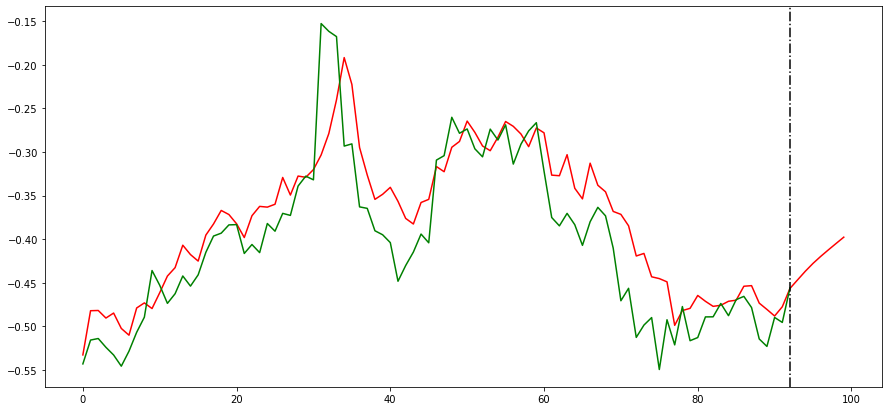

In [68]:
plt.figure(figsize = (15,7))
plt.plot(predicted[len(predicted)-100:], color = 'red')
plt.plot(y_test[len(y_test)-100+days:], color = 'g')
plt.axvline(100-days-1, 0, 1, linestyle = '-.' , color ='black')

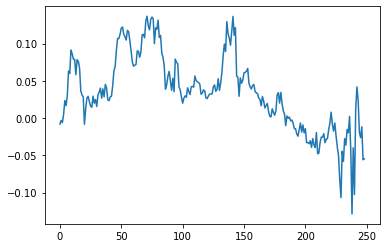